In [101]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import sigmoid
import matplotlib.colors as colors
from matplotlib import cm
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
dlc = dict(dlblue = '#0096ff', dlorange = '#FF9300', dldarkred='#C00000', dlmagenta='#FF40FF', dlpurple='#7030A0', dldarkblue =  '#0D5BDC')

## Dataset

In [102]:
def load_coffee_data():
    rng = np.random.default_rng(2)
    X = rng.random(400).reshape(-1,2)
    X[:,1] = X[:,1] * 4 + 11.5          # 12-15 min is best
    X[:,0] = X[:,0] * (285-150) + 150  # 350-500 F (175-260 C) is best
    Y = np.zeros(len(X))
    
    i=0
    for t,d in X:
        y = -3/(260-175)*t + 21
        if (t > 175 and t < 260 and d > 12 and d < 15 and d<=y ):
            Y[i] = 1
        else:
            Y[i] = 0
        i += 1

    return (X, Y.reshape(-1,1))

In [103]:
x, y = load_coffee_data()
print(x.shape, y.shape)

(200, 2) (200, 1)


In [104]:
def plt_roast(X,Y):
    Y = Y.reshape(-1,)
    colormap = np.array(['r', 'b'])
    fig, ax = plt.subplots(1,1,)
    ax.scatter(X[Y==1,0],X[Y==1,1], s=70, marker='x', c='red', label="Good Roast" )
    ax.scatter(X[Y==0,0],X[Y==0,1], s=100, marker='o', facecolors='none', 
               edgecolors=dlc["dldarkblue"],linewidth=1,  label="Bad Roast")
    tr = np.linspace(175,260,50)
    ax.plot(tr, (-3/85) * tr + 21, color=dlc["dlpurple"],linewidth=1)
    ax.axhline(y=12,color=dlc["dlpurple"],linewidth=1)
    ax.axvline(x=175,color=dlc["dlpurple"],linewidth=1)
    ax.set_title(f"Coffee Roasting", size=16)
    ax.set_xlabel("Temperature \n(Celsius)",size=12)
    ax.set_ylabel("Duration \n(minutes)",size=12)
    ax.legend(loc='upper right')
    plt.show()

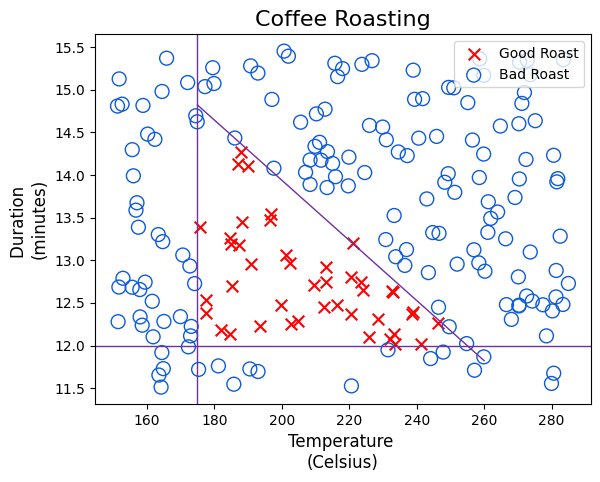

In [105]:
plt_roast(x, y)

## Normalize Data

In [106]:
print(f"Temperature Max, Min pre normalization: {np.max(x[:, 0]):0.2f}, {np.min(x[:, 0]):0.2f}")
print(f"Duration Max, Min pre normalization: {np.max(x[:,1]):0.2f}, {np.min(x[:,1]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis=-1)
norm_l.adapt(x)
xn = norm_l(x)
print(f"Temperature Max, Min post normalization: {np.max(x[:, 0]):0.2f}, {np.min(x[:, 0]):0.2f}")
print(f"Duration Max, Min post normalization: {np.max(x[:,1]):0.2f}, {np.min(x[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 284.99, 151.32
Duration Max, Min post normalization: 15.45, 11.51


In [107]:
xt = np.tile(xn, (1000,1))
yt = np.tile(y, (1000,1))
print(xt.shape, yt.shape)

(200000, 2) (200000, 1)


## Tensorflow Model

In [108]:
tf.random.set_seed(1234)
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name='layer1'),
        Dense(1, activation='sigmoid', name='layer2')
    ]
)

In [109]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                       │ (None, 3)                   │               9 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer2 (Dense)                       │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

In [110]:
L1_num_params = 2*3 + 3 #w1 parameters + b1 parameters
L2_num_params = 3*1 + 1 #w2 parameters + b2 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params)

L1 params =  9 , L2 params =  4


In [111]:
w1, b1 = model.get_layer("layer1").get_weights()
w2, b2 = model.get_layer("layer2").get_weights()
print(f"w1{w1.shape}:\n", w1, f"\nb1{b1.shape}:", b1)
print(f"w2{w2.shape}:\n", w2, f"\nb2{b2.shape}:", b2)

w1(2, 3):
 [[-0.01029682  0.0661087   0.6787026 ]
 [-0.69731605 -0.47731906 -1.0924968 ]] 
b1(3,): [0. 0. 0.]
w2(3, 1):
 [[0.04791164]
 [0.88366735]
 [0.14976454]] 
b2(1,): [0.]


In [112]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
)
model.fit(
    xt, yt, 
    epochs = 10
)

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.2771
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.1400
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.1361
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.1344
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.1330
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.1320
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.1314
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.1309
Epoch 9/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.1304
Epoch 10/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.1301


In [113]:
w1, b1 = model.get_layer("layer1").get_weights()
w2, b2 = model.get_layer("layer2").get_weights()
print("w1:\n", w1, "\nb1:", b1)
print("w2:\n", w2, "\nb2:", b2)

w1:
 [[ -7.53833     3.498818   11.526755 ]
 [ -2.2612603 -16.614847    8.457726 ]] 
b1: [-11.626737   17.489374   -1.2416639]
w2:
 [[-19.993439]
 [  7.638814]
 [-21.73384 ]] 
b2: [-5.4576483]


In [114]:
w1 = np.array( [
    [  -7.53833,     3.498818,   11.526755  ],
    [ -2.2612603, -16.614847,    8.457726  ]] )
b1 = np.array([ -11.626737,   17.489374,   -1.2416639])
w2 = np.array([
    [-19.993439 ],
    [ 7.638814],
    [-21.73384]] )
b2 = np.array([-5.4576483])
model.get_layer("layer1").set_weights([w1,b1])
model.get_layer("layer2").set_weights([w2,b2])

In [115]:
w1, b1 = model.get_layer("layer1").get_weights()
w2, b2 = model.get_layer("layer2").get_weights()
print("w1:\n", w1, "\nb1:", b1)
print("w2:\n", w2, "\nb2", b2)

w1:
 [[ -7.53833     3.498818   11.526755 ]
 [ -2.2612603 -16.614847    8.457726 ]] 
b1: [-11.626737   17.489374   -1.2416639]
w2:
 [[-19.993439]
 [  7.638814]
 [-21.73384 ]] 
b2 [-5.4576483]


## Predictions

In [116]:
x_test = np.array([
    [200, 13.9],
    [200, 17] ])
x_testn = norm_l(x_test)
predictions = model.predict(x_testn)
print("Predictions = \n", predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Predictions = 
 [[7.7707410e-01]
 [1.5519732e-12]]


In [117]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)):
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"Decisions = \n{yhat}")

Decisions = 
[[1.]
 [0.]]


In [118]:
yhat = (predictions >= 0.5).astype(int)
print(f"Decisions = \n{yhat}")

Decisions = 
[[1]
 [0]]


## Layer Functions

In [119]:
def plt_prob(ax,fwb):
    """ plots a decision boundary but include shading to indicate the probability """
    #setup useful ranges and common linspaces
    x0_space  = np.linspace(150, 285 , 40)
    x1_space  = np.linspace(11.5, 15.5 , 40)

    # get probability for x0,x1 ranges
    tmp_x0,tmp_x1 = np.meshgrid(x0_space,x1_space)
    z = np.zeros_like(tmp_x0)
    for i in range(tmp_x0.shape[0]):
        for j in range(tmp_x1.shape[1]):
            x = np.array([[tmp_x0[i,j],tmp_x1[i,j]]])
            z[i,j] = fwb(x)


    cmap = plt.get_cmap('Blues')
    new_cmap = truncate_colormap(cmap, 0.0, 0.5)
    pcm = ax.pcolormesh(tmp_x0, tmp_x1, z,
                   norm=cm.colors.Normalize(vmin=0, vmax=1),
                   cmap=new_cmap, shading='nearest', alpha = 0.9)
    ax.figure.colorbar(pcm, ax=ax)

    
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """ truncates color map """
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [120]:
def plt_layer(X,Y,W1,b1,norm_l):
    Y = Y.reshape(-1,)
    fig,ax = plt.subplots(1,W1.shape[1], figsize=(16,4))
    for i in range(W1.shape[1]):
        layerf= lambda x : sigmoid(np.dot(norm_l(x),W1[:,i]) + b1[i])
        plt_prob(ax[i], layerf)
        ax[i].scatter(X[Y==1,0],X[Y==1,1], s=70, marker='x', c='red', label="Good Roast" )
        ax[i].scatter(X[Y==0,0],X[Y==0,1], s=100, marker='o', facecolors='none', 
                   edgecolors=dlc["dldarkblue"],linewidth=1,  label="Bad Roast")
        tr = np.linspace(175,260,50)
        ax[i].plot(tr, (-3/85) * tr + 21, color=dlc["dlpurple"],linewidth=2)
        ax[i].axhline(y= 12, color=dlc["dlpurple"], linewidth=2)
        ax[i].axvline(x=175, color=dlc["dlpurple"], linewidth=2)
        ax[i].set_title(f"Layer 1, unit {i}")
        ax[i].set_xlabel("Temperature \n(Celsius)",size=12)
    ax[0].set_ylabel("Duration \n(minutes)",size=12)
    plt.show()

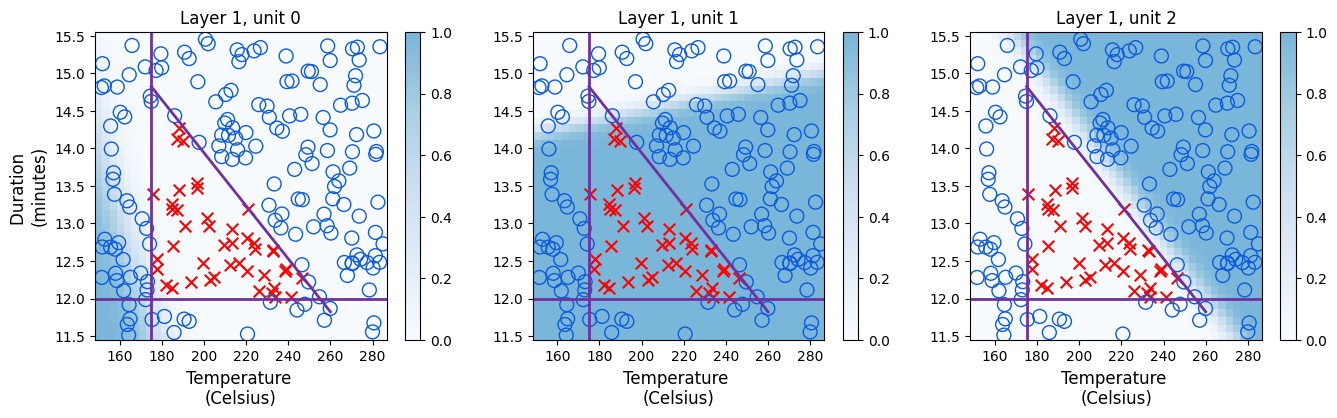

In [122]:
plt_layer(x, y.reshape(-1,), w1, b1, norm_l)

In [123]:
def plt_output_unit(W,b):
    """ plots a single unit function with 3 inputs """
    steps = 10
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    x_ = np.linspace(0., 1., steps)
    y_ = np.linspace(0., 1., steps)
    z_ = np.linspace(0., 1., steps)
    x, y, z = np.meshgrid(x_, y_, z_, indexing='ij')
    d = np.zeros((steps,steps,steps))
    cmap = plt.get_cmap('Blues')
    for i in range(steps):
        for j in range(steps):
            for k in range(steps):
                v = np.array([x[i,j,k],y[i,j,k],z[i,j,k]])
                d[i,j,k] = tf.keras.activations.sigmoid(
                    np.dot(v, W[:,0]) + b
                ).numpy().item()

    pcm = ax.scatter(x, y, z, c=d, cmap=cmap, alpha = 1 )
    ax.set_xlabel("unit 0"); 
    ax.set_ylabel("unit 1"); 
    ax.set_zlabel("unit 2"); 
    ax.view_init(30, -120)
    ax.figure.colorbar(pcm, ax=ax)
    ax.set_title(f"Layer 2, output unit")

    plt.show()

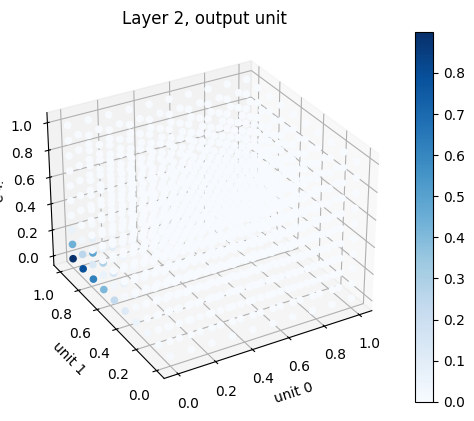

In [124]:
plt_output_unit(w2, b2)

In [125]:
def plt_network(X,Y,netf):
    fig, ax = plt.subplots(1,2,figsize=(16,4))
    Y = Y.reshape(-1,)
    plt_prob(ax[0], netf)
    ax[0].scatter(X[Y==1,0],X[Y==1,1], s=70, marker='x', c='red', label="Good Roast" )
    ax[0].scatter(X[Y==0,0],X[Y==0,1], s=100, marker='o', facecolors='none', 
                   edgecolors=dlc["dldarkblue"],linewidth=1,  label="Bad Roast")
    ax[0].plot(X[:,0], (-3/85) * X[:,0] + 21, color=dlc["dlpurple"],linewidth=1)
    ax[0].axhline(y= 12, color=dlc["dlpurple"], linewidth=1)
    ax[0].axvline(x=175, color=dlc["dlpurple"], linewidth=1)
    ax[0].set_xlabel("Temperature \n(Celsius)",size=12)
    ax[0].set_ylabel("Duration \n(minutes)",size=12)
    ax[0].legend(loc='upper right')
    ax[0].set_title(f"network probability")

    ax[1].plot(X[:,0], (-3/85) * X[:,0] + 21, color=dlc["dlpurple"],linewidth=1)
    ax[1].axhline(y= 12, color=dlc["dlpurple"], linewidth=1)
    ax[1].axvline(x=175, color=dlc["dlpurple"], linewidth=1)
    fwb = netf(X)
    yhat = (fwb > 0.5).astype(int)
    ax[1].scatter(X[yhat[:,0]==1,0],X[yhat[:,0]==1,1], s=70, marker='x', c='orange', label="Predicted Good Roast" )
    ax[1].scatter(X[yhat[:,0]==0,0],X[yhat[:,0]==0,1], s=100, marker='o', facecolors='none', 
                   edgecolors=dlc["dldarkblue"],linewidth=1,  label="Predicted Bad Roast")
    ax[1].set_title(f"network decision")
    ax[1].set_xlabel("Temperature \n(Celsius)",size=12)
    ax[1].set_ylabel("Duration \n(minutes)",size=12)
    ax[1].legend(loc='upper right')


C:\Users\ayush\AppData\Local\Temp\ipykernel_1948\4237154889.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i,j] = fwb(x)


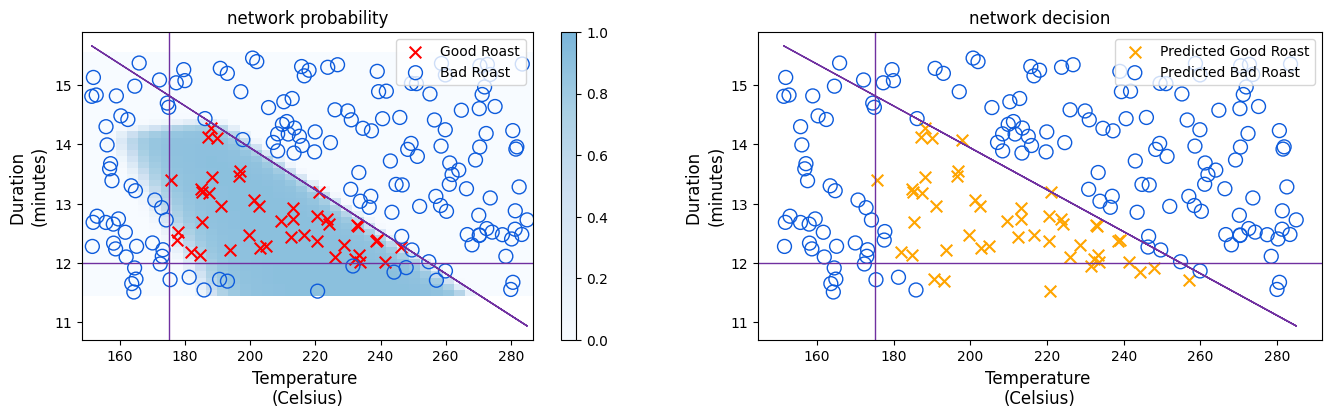

In [126]:
netf = lambda x: model.predict(norm_l(x), verbose=0)
plt_network(x, y, netf)